From all mice, look at different onsets of investigations and the associated response

In [19]:
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJECT_ROOT)

from experiment_class import Experiment
from Hab_Dishab.hd_extension import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
# NAc
experiment_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined\Hab_Dishab\All\nac"
csv_base_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined\Hab_Dishab\All\nac_csvs"
brain_region = '#15616F'


# mPFC
# experiment_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined\Hab_Dishab\All\mpfc"
# csv_base_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined\Hab_Dishab\All\mpfc_csvs"
# brain_region = '#FFAF00'

trial.remove_initial_LED_artifact(t=30)
trial.remove_final_data_segment(t = 10)

trial.smooth_and_apply(window_len=int(trial.fs)*1)
trial.apply_ma_baseline_drift()
trial.compute_zscore(method = 'standard')
trial.verify_signal()

csv_file_name = f"{trial_folder}.csv"
csv_file_path = os.path.join(self.behavior_folder_path, csv_file_name)
trial.extract_manual_annotation_behaviors(csv_file_path)

In [21]:
experiment = Experiment(experiment_path, csv_base_path)

experiment.default_batch_process()

Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined\Hab_Dishab\All\nac\n4-240507-140651\Notes.txt
read from t=0s to t=1318.23s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined\Hab_Dishab\All\nac\n5-240821-085040\Notes.txt
read from t=0s to t=1324.06s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined\Hab_Dishab\All\nac\n6-240821-100116\Notes.txt
read from t=0s to t=1335.06s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined\Hab_Dishab\All\nac\n7-240821-114717\Notes.txt
read from t=0s to t=1309.86s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined\Hab_Dishab\All\nac\nn1-250115-052028\Notes.txt
read from t=0s to t=1351.05s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined\Hab_Dishab\All\nac\nn2-250115-054951\Notes.txt
read from t=0s to t=1349.

In [22]:
# bout_definitions = [
#     {'prefix': 'Short_Term-1', 'introduced': 'Short_Term_Introduced', 'removed': 'Short_Term_Removed'},
#     {'prefix': 'Short_Term-2', 'introduced': 'Short_Term_Introduced', 'removed': 'Short_Term_Removed'},
#     {'prefix': 'Long_Term-1', 'introduced': 'Long_Term_Introduced', 'removed': 'Long_Term_Removed'},
#     {'prefix': 'Novel-1', 'introduced': 'Novel_Introduced', 'removed': 'Novel_Removed'}
# ]

bout_definitions = [
    {'prefix': 's1', 'introduced': 's1_Introduced', 'removed': 's1_Removed'},
    {'prefix': 's2', 'introduced': 's2_Introduced', 'removed': 's2_Removed'}
]
experiment.group_extract_manual_annotations(bout_definitions,first_only=False)

Processing behaviors for n4-240507-140651...
Processing behaviors for n5-240821-085040...
Processing behaviors for n6-240821-100116...
Processing behaviors for n7-240821-114717...
Processing behaviors for nn1-250115-052028...
Processing behaviors for nn2-250115-054951...
Processing behaviors for nn3-250115-064154...
Processing behaviors for nn4-250115-072812...
Processing behaviors for nn5-250114-083827...
Processing behaviors for nn6-250114-093117...
Processing behaviors for nn7-250114-100133...
Processing behaviors for nn8-250114-103839...


In [ ]:
# Proceed with DA metric computation after all files are processed
experiment.compute_all_da_metrics(use_max_length=False,
                                  max_bout_duration=100, 
                                  use_adaptive=True, 
                                  allow_bout_extension=True,
                                  mode='standard')

Computing DA metrics for n4-240507-140651 ...
Computing DA metrics for n5-240821-085040 ...
Computing DA metrics for n6-240821-100116 ...
Computing DA metrics for n7-240821-114717 ...
Computing DA metrics for nn1-250115-052028 ...
Computing DA metrics for nn2-250115-054951 ...
Computing DA metrics for nn3-250115-064154 ...
Computing DA metrics for nn4-250115-072812 ...
Computing DA metrics for nn5-250114-083827 ...
Computing DA metrics for nn6-250114-093117 ...
Computing DA metrics for nn7-250114-100133 ...
Computing DA metrics for nn8-250114-103839 ...


In [24]:
exp_dict = get_trial_dataframes(experiment)

In [25]:
desired_bouts = ['s1-1', 's1-2', 's1-3', 's1-4', 's1-5', 's2-1']
metadata_df = create_metadata_dataframe(exp_dict, behavior="Investigation", desired_bouts=desired_bouts)

In [26]:
metadata_df.head()

,Subject,Bout,Behavior,Total Investigation Time,Average Bout Duration
0,n4,s1-1,Investigation,109.800,27.450000
1,n4,s1-2,Investigation,35.800,5.114286
2,n4,s1-3,Investigation,44.865,4.486500
3,n4,s1-4,Investigation,15.266,1.696222
4,n4,s1-5,Investigation,6.065,1.010833


In [27]:
total_avg_bout_duration = metadata_df["Average Bout Duration"].mean()
print(f"Total Average Bout Duration: {total_avg_bout_duration:.4f}")

Total Average Bout Duration: 3.6326


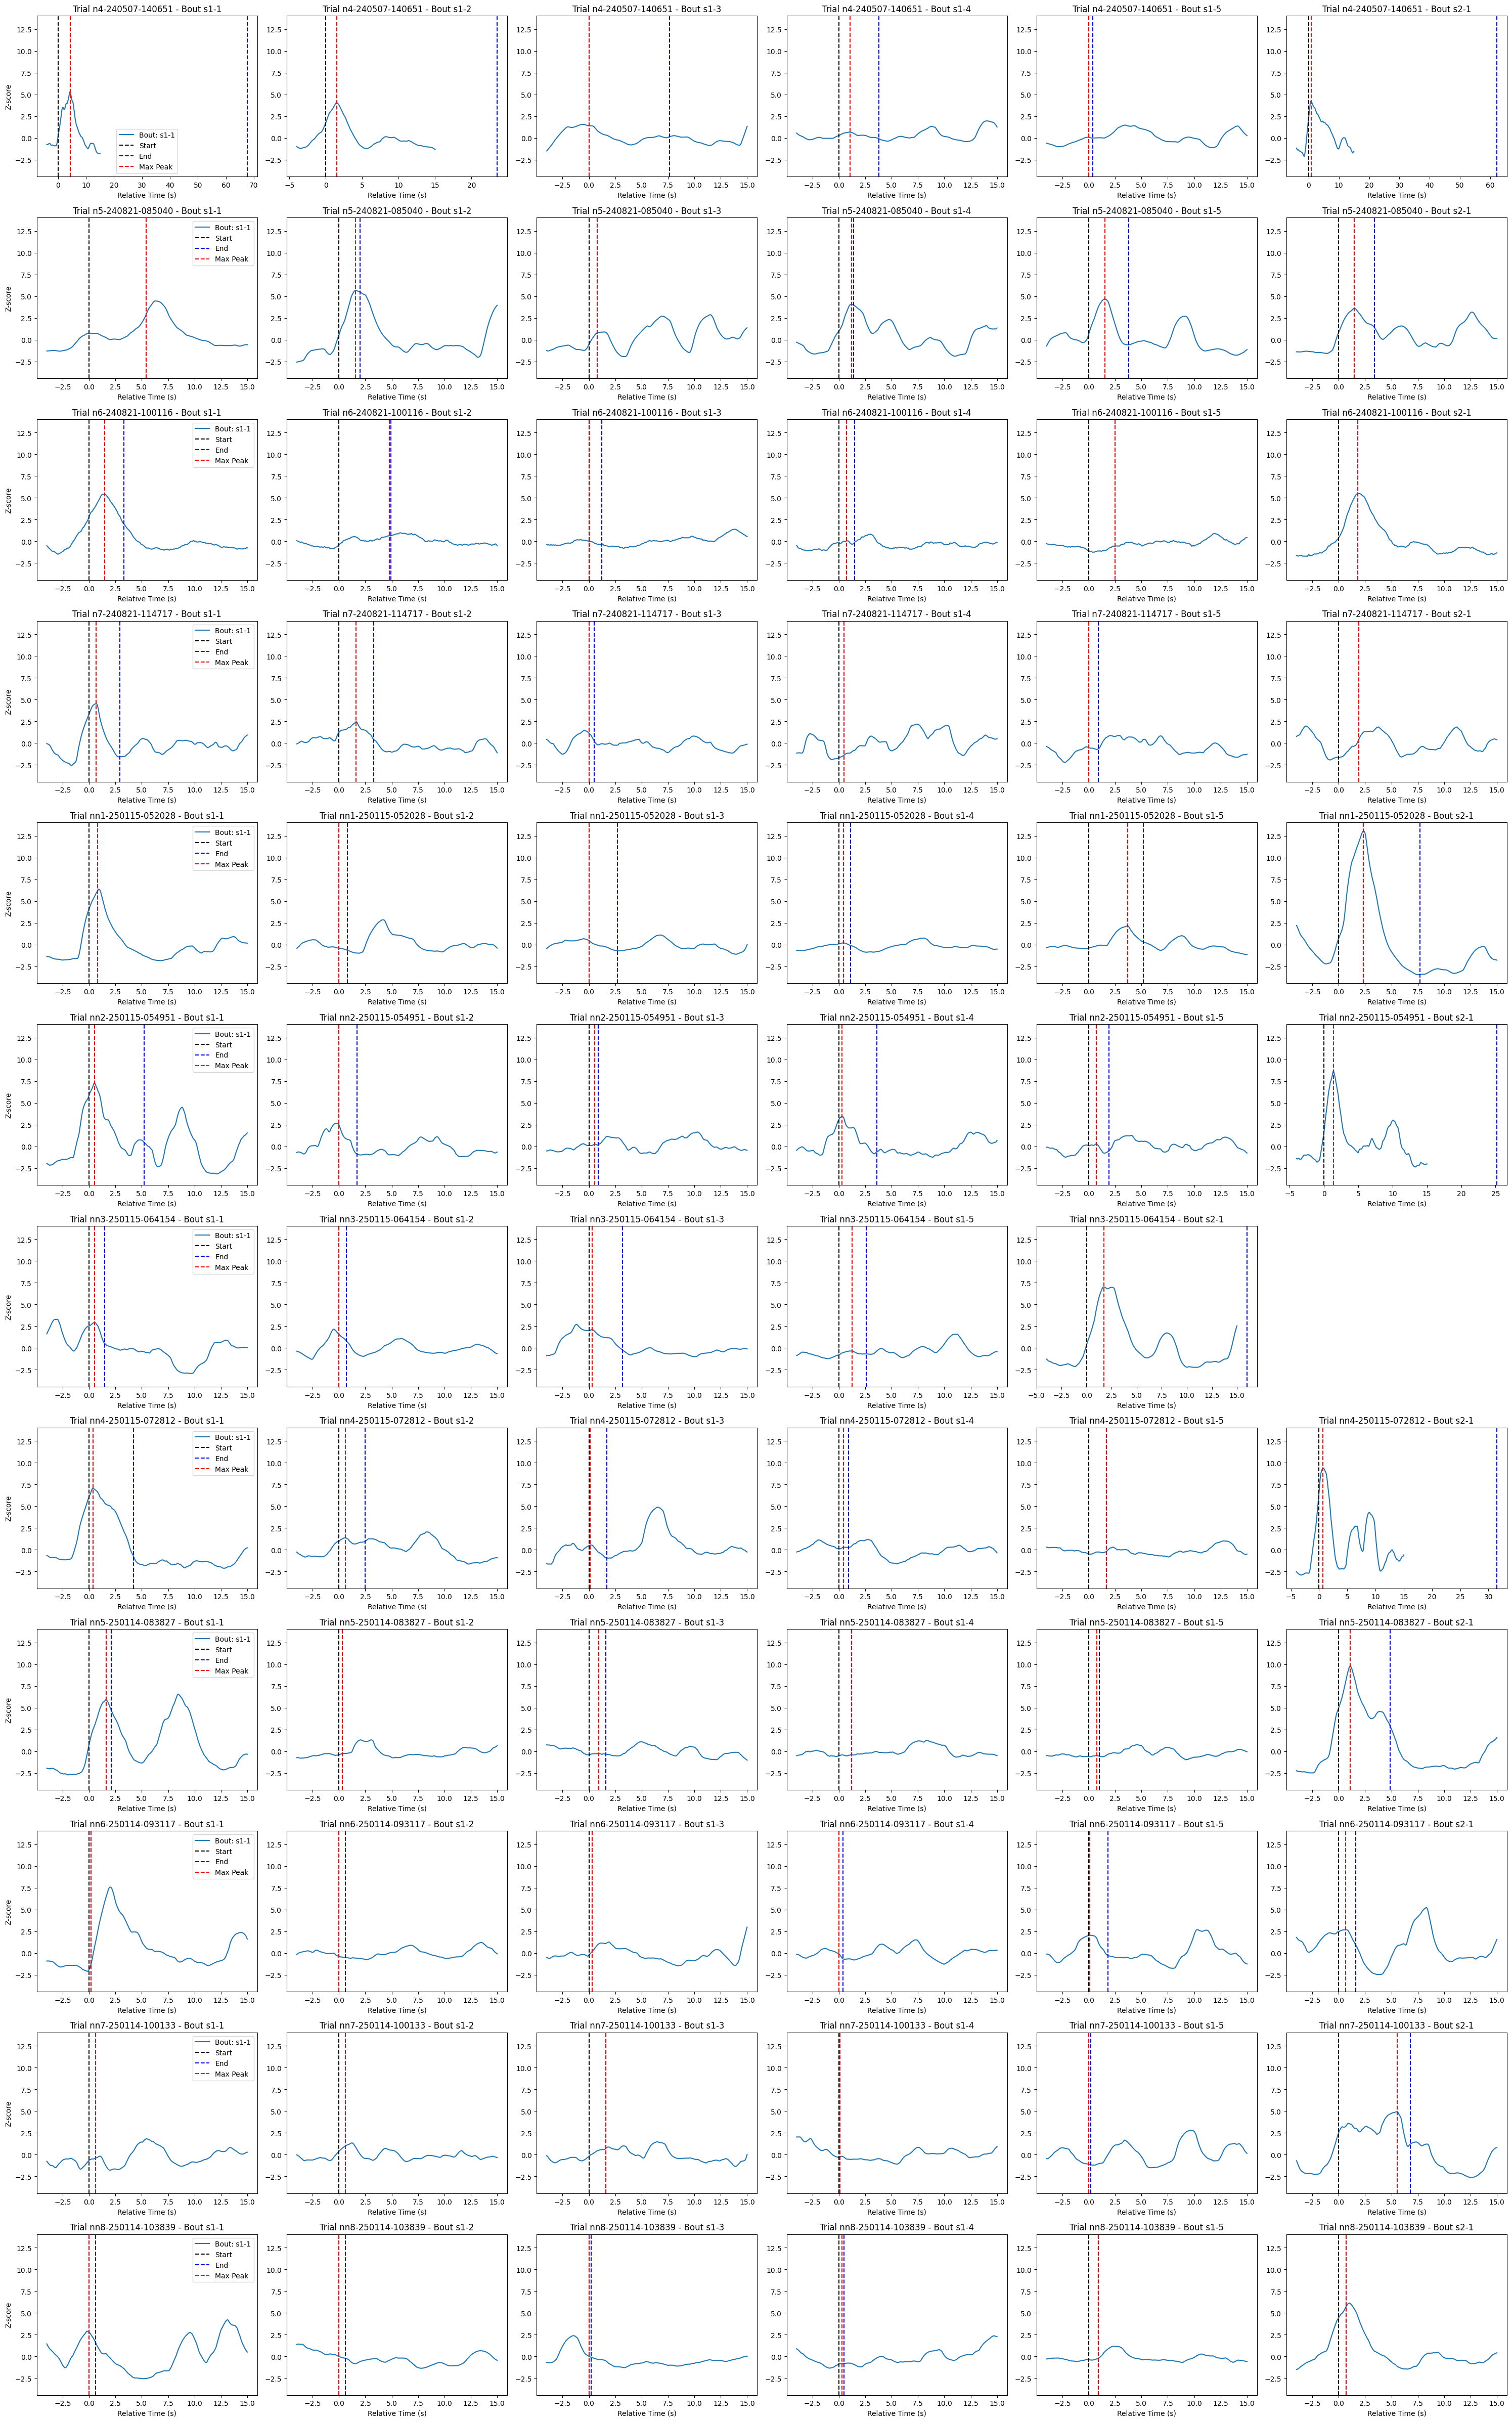

In [28]:
desired_bouts = ['s1-1', 's1-2', 's1-3', 's1-4', 's1-5', 's2-1']
experiment.plot_first_behavior_PETHs(selected_bouts=desired_bouts)

In [29]:
# df = experiment.trials['nn2-250115-054951'].behaviors
df = experiment.trials['nn3-250115-064154'].behaviors
# print(df['Event_Zscore'])
# df.plot_first_behavior_PETHs()
df

,Bout,Behavior,Event_Start,Event_End,Duration (s),AUC,Max Peak,Time of Max Peak,Mean Z-score,Adjusted End,Relative_Time_Axis,Relative_Zscore
0,s1-1,Approach,226.8,228.599,1.799,0.676803,1.266802,1.798083,0.376476,228.599,"[-4.0, -3.999016960019661, -3.9980339200393216...","[0.09267425645363593, 0.09337166663506949, 0.0..."
1,s1-1,Investigation,205.9,207.400,1.500,3.243696,2.943367,0.538396,2.163284,207.400,"[-4.0, -3.999016960019661, -3.9980339200393216...","[1.6289078495568814, 1.6297198444278842, 1.632..."
2,s1-1,Investigation,228.6,229.700,1.100,1.367643,1.375909,0.224182,1.244156,229.700,"[-4.0, -3.999016960019661, -3.9980339200393216...","[-0.33142280866527907, -0.33248771875111477, -..."
3,s1-1,Investigation,237.6,239.200,1.600,-0.146992,0.343911,0.088254,-0.091950,239.200,"[-4.0, -3.999016960019661, -3.9980339200393216...","[-0.577726474142639, -0.5776276821404575, -0.5..."
4,s1-1,Investigation,281.0,282.200,1.200,-0.343561,-0.225508,0.460075,-0.286492,282.200,"[-4.0, -3.999016960019661, -3.9980339200393216...","[-0.37845726962910503, -0.37829820972277256, -..."
5,s1-1,Investigation,288.5,288.900,0.400,0.032169,0.296922,0.000607,0.080639,288.900,"[-4.0, -3.999016960019661, -3.9980339200393216...","[-0.34892567813648434, -0.3489142261060525, -0..."
6,s1-2,Investigation,409.3,410.000,0.700,0.843986,1.575930,0.000492,1.207502,410.000,"[-4.0, -3.999016960019661, -3.9980339200393216...","[-0.365003853503226, -0.365215701431131, -0.36..."
7,s1-2,Investigation,455.2,455.800,0.600,-0.177984,-0.089027,0.000595,-0.297261,455.800,"[-4.0, -3.999016960019661, -3.9980339200393216...","[-0.5697719101694094, -0.5697217069400567, -0...."
8,s1-2,Investigation,486.5,486.600,0.100,-0.115918,-1.149318,0.099875,-1.167507,486.600,"[-4.0, -3.999016960019661, -3.9980339200393216...","[2.8104051700042416, 2.8091269201680467, 2.805..."
9,s1-3,Approach,611.1,614.899,3.799,4.830142,2.713315,2.622673,1.271750,614.899,"[-4.0, -3.999016960019661, -3.9980339200393216...","[-0.3726649235855675, -0.37268337998769446, -0..."


PETH

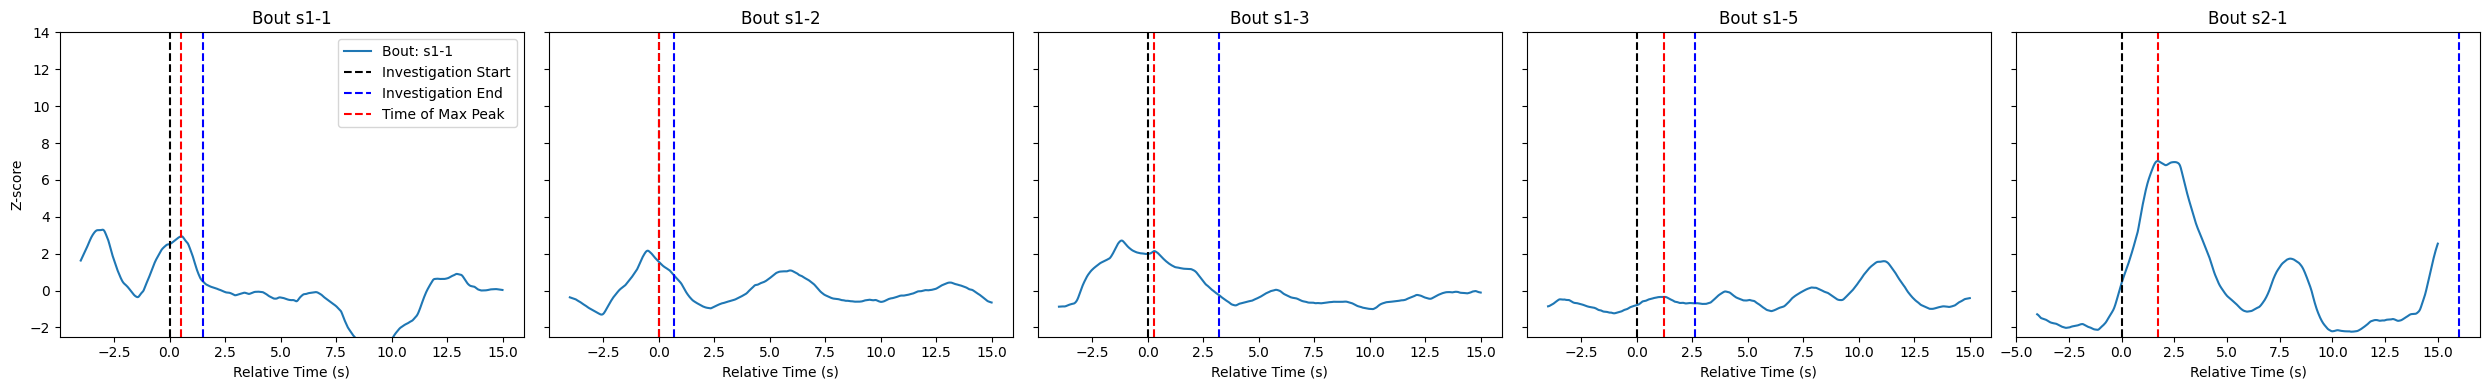

In [30]:
# 1. Filter to only 'Investigation' rows
df_invest = df[df["Behavior"] == "Investigation"].copy()

# 2. Identify the first investigation of each bout.
#    - If your "Bout" column is already something like 's1-1', 's1-2', etc., you can group by it directly.
#    - Then select the first row in each group (based on order in df).
df_first_invest = df_invest.groupby("Bout", as_index=False).first()

# Number of plots equals the number of first investigations
n_plots = len(df_first_invest)

# Create side-by-side subplots
fig, axes = plt.subplots(1, n_plots, figsize=(5*n_plots, 4), sharey=True)

# If only one bout, make axes iterable
if n_plots == 1:
    axes = [axes]

for i, (_, row) in enumerate(df_first_invest.iterrows()):
    ax = axes[i]
    
    # Extract arrays for plotting
    x = row["Relative_Time_Axis"]  
    y = row["Relative_Zscore"]  
    
    # Plot main investigation trace
    ax.plot(x, y, label=f"Bout: {row['Bout']}")

    # Dashed black line at investigation start (x=0)
    ax.axvline(x=0, color='black', linestyle='--', label="Investigation Start")

    # Dashed blue line at investigation end (x = duration)
    end_time = row["Duration (s)"]
    ax.axvline(x=end_time, color='blue', linestyle='--', label="Investigation End")

    # Dashed red line at time of max peak
    max_peak_time = row["Time of Max Peak"]
    ax.axvline(x=max_peak_time, color='red', linestyle='--', label="Time of Max Peak")

    # Keep Y-limits consistent
    ax.set_ylim([-2.5, 14])

    # Titles and labels
    ax.set_title(f"Bout {row['Bout']}")
    ax.set_xlabel("Relative Time (s)")

# Common Y-axis label
axes[0].set_ylabel("Z-score")

# Optional legend handling (show only in the first subplot)
axes[0].legend()

plt.tight_layout()
plt.show()


In [31]:
# For all subjects, plot PETH of both standard and relative for first investigation and second investigation
# Look at PETH for all combined
# Look into peak and trough thing. Does it make a difference in the bar plots?

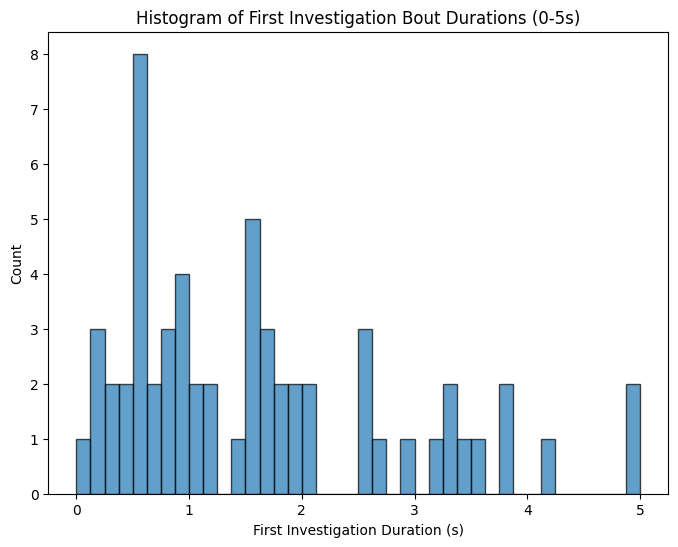

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Collect first investigation durations from all trials
first_investigation_durations = []

for trial_name, trial in experiment.trials.items():
    if hasattr(trial, 'behaviors') and not trial.behaviors.empty:
        # Filter only the first investigation per bout
        first_investigations = (
            trial.behaviors[trial.behaviors["Behavior"] == "Investigation"]
            .sort_values("Event_Start")
            .groupby("Bout", as_index=False)
            .first()
        )

        # Compute duration
        durations = first_investigations["Event_End"] - first_investigations["Event_Start"]
        first_investigation_durations.extend(durations.tolist())

# Convert to NumPy array for safety and filter between 0-5s
first_investigation_durations = np.array(first_investigation_durations)
filtered_durations = first_investigation_durations[
    (first_investigation_durations >= 0) & (first_investigation_durations <= 5)
]

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(filtered_durations, bins=40, range=(0, 5), edgecolor='black', alpha=0.7)
plt.xlabel("First Investigation Duration (s)")
plt.ylabel("Count")
plt.title("Histogram of First Investigation Bout Durations (0-5s)")
plt.show()


In [33]:
for trial_name, trial in experiment.trials.items():
    if hasattr(trial, 'behaviors') and not trial.behaviors.empty:
        df = trial.behaviors
        # print(df)
        # Copy old metrics into new columns
        df["OG_AUC"]            = df["AUC"]
        df["OG_Max Peak"]       = df["Max Peak"]
        df["OG_Time of Max Peak"] = df["Time of Max Peak"]
        df["OG_Mean Z-score"]   = df["Mean Z-score"]
        
        # Copy the old end times
        if "Original End" in df.columns:
            df["OG_Original End"] = df["Original End"]
        if "Adjusted End" in df.columns:
            df["OG_Adjusted End"] = df["Adjusted End"]

In [34]:
experiment.compute_all_da_metrics(
    use_fractional=False, 
    max_bout_duration=3, 
    use_adaptive=True, 
    peak_fall_fraction=0.5,
    allow_bout_extension=True,
    first=True
)

TypeError: Experiment.compute_all_da_metrics() got an unexpected keyword argument 'use_fractional'

In [ ]:
all_changed_rows = []

for trial_name, trial in experiment.trials.items():
    if hasattr(trial, 'behaviors') and not trial.behaviors.empty:
        df = trial.behaviors
        # Identify rows where the new "Adjusted End" differs from the "Original End"
        changed_df = df[df["Adjusted End"] != df["Original End"]].copy()
        
        if not changed_df.empty:
            # Insert subject name (or trial name) in the first column
            changed_df.insert(0, "Subject", trial.subject_name)
            all_changed_rows.append(changed_df)

if all_changed_rows:
    final_changed_df = pd.concat(all_changed_rows, ignore_index=True)
    final_changed_df.to_csv("adjusted_end_changes.csv", index=False)
    print("Saved rows with changed end times (plus original metrics) to adjusted_end_changes.csv")
else:
    print("No adjusted end times differ from the original end times.")

Saved rows with changed end times (plus original metrics) to adjusted_end_changes.csv


In [ ]:
final_changed_df.head()

,Subject,Bout,Behavior,Event_Start,Event_End,Duration (s),AUC,Max Peak,Time of Max Peak,Mean Z-score,Original End,Adjusted End,OG_AUC,OG_Max Peak,OG_Time of Max Peak,OG_Mean Z-score,OG_Original End,OG_Adjusted End
0,n1,s1-1,Investigation,182.000,184.800,2.800,5.416181,1.513838,185.304019,0.883660,184.800,188.128293,1.705989,1.118747,184.799720,0.609229,184.800,184.800
1,n1,s1-2,Investigation,383.867,384.267,0.400,5.578763,2.641122,385.707533,1.144364,384.267,388.741194,-0.063123,0.009569,384.266396,-0.158038,384.267,384.267
2,n2,s1-2,Investigation,376.067,377.867,1.800,1.636603,1.149407,377.629893,0.634245,377.867,378.647340,0.965125,1.149407,377.629893,0.536374,377.867,377.867
3,n2,s2-1,Investigation,1358.867,1359.533,0.666,0.856529,0.863525,1360.038762,0.442635,1359.533,1360.801601,-0.027972,0.522379,1359.532496,-0.042132,1359.533,1359.533
4,n3,s1-1,Investigation,190.333,231.067,40.734,5.507158,2.572328,209.707004,0.271858,231.067,210.591740,2.468544,2.572328,209.707004,0.060590,231.067,231.067


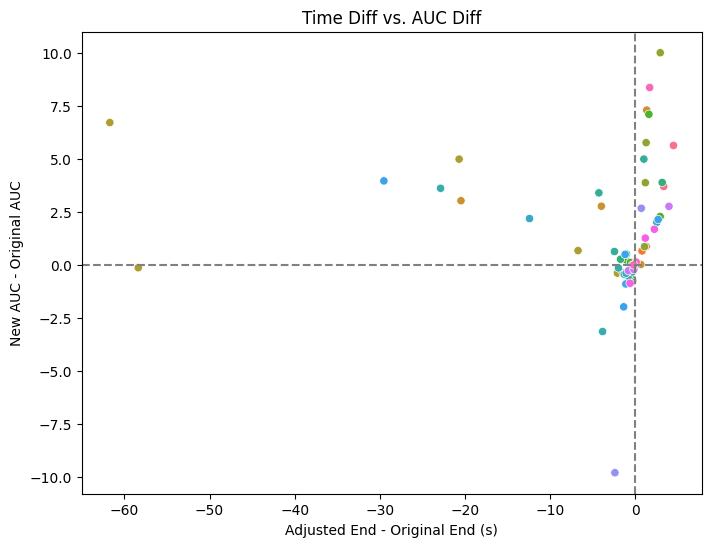

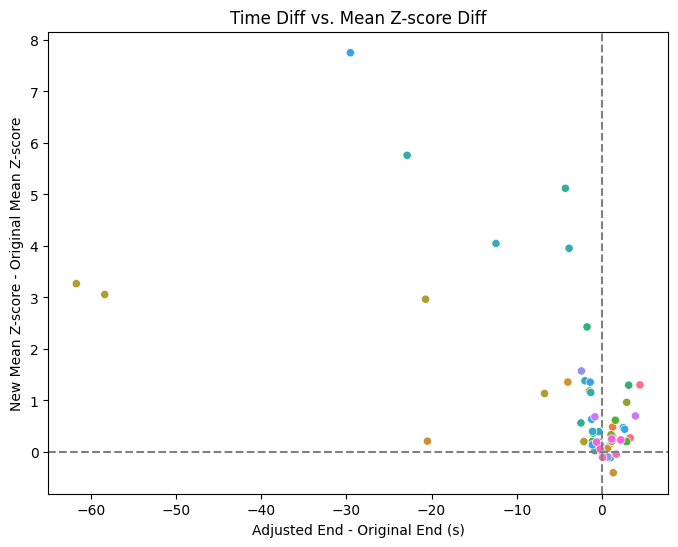

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Create difference columns
#    - time_diff < 0 => bout got shorter
#    - time_diff > 0 => bout got longer
final_changed_df["time_diff"] = final_changed_df["Adjusted End"] - final_changed_df["Original End"]
final_changed_df["auc_diff"] = final_changed_df["AUC"] - final_changed_df["OG_AUC"]
final_changed_df["mean_diff"] = final_changed_df["Mean Z-score"] - final_changed_df["OG_Mean Z-score"]

# 2. Plot time_diff vs. auc_diff
plt.figure(figsize=(8, 6))
sns.scatterplot(data=final_changed_df, x="time_diff", y="auc_diff", hue="Subject")
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.title("Time Diff vs. AUC Diff")
plt.xlabel("Adjusted End - Original End (s)")
plt.ylabel("New AUC - Original AUC")
plt.legend([], [], frameon=False)  # Remove legend

plt.show()

# 3. Plot time_diff vs. mean_diff
plt.figure(figsize=(8, 6))
sns.scatterplot(data=final_changed_df, x="time_diff", y="mean_diff", hue="Subject")
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.title("Time Diff vs. Mean Z-score Diff")
plt.xlabel("Adjusted End - Original End (s)")
plt.ylabel("New Mean Z-score - Original Mean Z-score")
plt.legend([], [], frameon=False)  # Remove legend

plt.show()


In [ ]:
# Grab associated DA levels for each investigtation. Look at first investigation DA. 
# provides area under the curve, max peak height, max z-scored ΔF/F, and the time at which the max ΔF/F value occurs.

In [ ]:
# Look at DA for super long investigation bouts. See what's up. Look at DA for all investigations. See if there's a difference between the two

In [ ]:
# This is looking at NAc, look at mPFC too

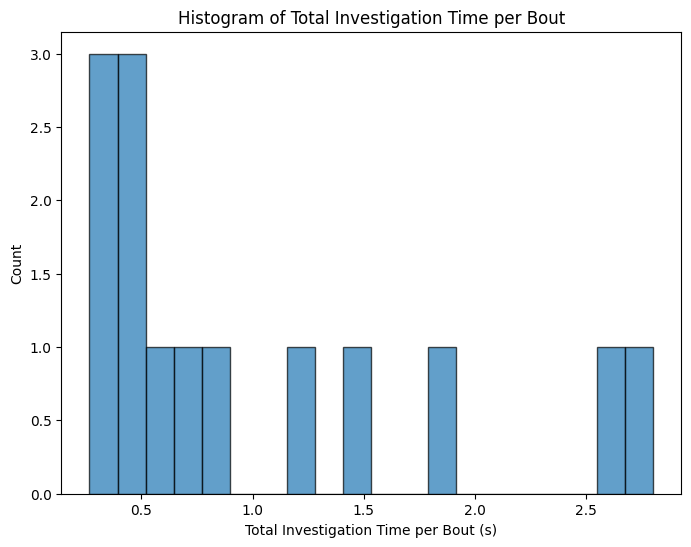

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Collect investigation data from all trials
investigation_data = []

for trial_name, trial in experiment.trials.items():
    if hasattr(trial, 'behaviors') and not trial.behaviors.empty:
        # Add subject information if missing
        if "Subject" not in trial.behaviors.columns:
            trial.behaviors["Subject"] = trial_name  # Assign trial name as Subject

        # Filter only "Investigation" behaviors
        investigation_df = trial.behaviors[trial.behaviors["Behavior"] == "Investigation"].copy()

        # Ensure "Duration (s)" exists, or calculate it
        if "Duration (s)" not in investigation_df.columns:
            investigation_df["Duration (s)"] = investigation_df["Event_End"] - investigation_df["Event_Start"]

        # Group by Subject and Bout to compute total investigation time
        grouped = (
            investigation_df
            .groupby(["Subject", "Bout"], as_index=False)
            .agg(Total_Investigation_Time=("Duration (s)", "sum"))  # Total time spent investigating
        )

        # Append to list
        investigation_data.append(grouped)

# Concatenate results from all trials into one DataFrame
if investigation_data:
    investigation_stats = pd.concat(investigation_data, ignore_index=True)
else:
    investigation_stats = pd.DataFrame(columns=["Subject", "Bout", "Total invest"])

# Extract total investigation time per bout
total_investigation_times = investigation_stats["Total_Investigation_Time"]

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(total_investigation_times, bins=20, edgecolor="black", alpha=0.7)
plt.xlabel("Total Investigation Time per Bout (s)")
plt.ylabel("Count")
plt.title("Histogram of Total Investigation Time per Bout")
plt.show()
